In [13]:
import pickle
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances, accuracy_score
from scipy.spatial.distance import cdist, pdist
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn_lvq import GlvqModel
from scipy.special import softmax

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib notebook

sns.set(font_scale=2)
sns.set_style('white')
sns.set_context('poster')

In [2]:
def bipolarize(Y):
    X = np.copy(Y)
    X[X > 0] = 1.0
    X[X < 0] = -1.0
    X[X == 0] = np.random.choice([-1.0, 1.0], size=len(X[X == 0]))
    return X

In [3]:
def centroids(X,label=None):
    if label is not None:
        cLabel = np.unique(label)
        c = np.zeros((len(cLabel), X.shape[1]))
        for i,l in enumerate(cLabel):
            c[i,:] = bipolarize(np.sum(X[label==l],axis=0))
    else:
        c = bipolarize(np.sum(X,axis=0)).reshape(1,-1)
        cLabel = [0]
    return cLabel, c.astype('int')

In [4]:
def classify(v,am,metric):
    d = cdist(v,am,metric)
    label = np.argmin(d,axis=1)
    return label

In [5]:
# select dataset and encoding type
dataName = 'allHV.npz'
emgHVType =  'hvRelAcc'

allHV = np.load(dataName)

# extract data and labels based on gesture, trial, and position
hv = allHV[emgHVType]
gestLabel = allHV['gestLabel']
posLabel = allHV['posLabel']
trialLabel = allHV['trialLabel']

combGP, groupGP = np.unique(np.column_stack((gestLabel,posLabel)),axis=0,return_inverse=True)
combGPT, groupGPT = np.unique(np.column_stack((gestLabel,posLabel,trialLabel)),axis=0,return_inverse=True)

# get list of unique values for each label
gestures = np.unique(gestLabel)
positions = np.unique(posLabel)
trials = np.unique(trialLabel)

numGestures = len(gestures)
numPositions = len(positions)
numTrials = len(trials)

# get data size info
D = hv.shape[1] # hypervector dimension
numHV = 80 # number of examples per trial

# color palettes for plotting
gPalette = sns.color_palette('tab20', numGestures)
pPalette = sns.color_palette('tab20', numPositions)

In [6]:
numSplit = 10
skf = StratifiedKFold(n_splits=numSplit)

X = hv
y = gestLabel
c = posLabel
g = groupGP

splitIdx = 0
numIter = 20

acc = np.zeros((numSplit,numIter,numGestures,numPositions,2))
posWeights = np.ones((numSplit,numIter,numGestures,numPositions))*0.125


for trainIdx, testIdx in skf.split(X,g):
    print('Running cross validation split %d of %d...' % (splitIdx+1, numSplit))
    XTrain, XTest = X[trainIdx], X[testIdx]
    yTrain, yTest = y[trainIdx], y[testIdx]
    cTrain, cTest = c[trainIdx], c[testIdx]
    gTrain, gTest = g[trainIdx], g[testIdx]
    
    # get accuracy from equally weighting each arm position
    alpha = 0.2
    for n in range(numIter):
        weightMat = np.zeros(len(XTrain))
        for gest in gestures:
            for pos in positions:
                weightMat[(yTrain==gest) & (cTrain==pos)] = posWeights[splitIdx,n,gest,pos]
        weightMat = weightMat.reshape(-1,1)
        
        AM = centroids(XTrain*weightMat,label=yTrain)[1]
        
        for gest in gestures:
            for pos in positions:
                acc[splitIdx,n,gest,pos,0] = accuracy_score(classify(XTrain[(yTrain==gest) & (cTrain==pos)],AM,'hamming'),yTrain[(yTrain==gest) & (cTrain==pos)])
                acc[splitIdx,n,gest,pos,1] = accuracy_score(classify(XTest[(yTest==gest) & (cTest==pos)],AM,'hamming'),yTest[(yTest==gest) & (cTest==pos)])
        for gest in gestures:
            if n < numIter - 1:
                deltaWeights = softmax(1 - acc[splitIdx,n,gest,:,0])
                posWeights[splitIdx,n+1,gest,:] = posWeights[splitIdx,n,gest,:] + deltaWeights*alpha
                posWeights[splitIdx,n+1,gest,:] = posWeights[splitIdx,n+1,gest,:]/np.sum(posWeights[splitIdx,n+1,gest,:])
#         alpha *= 1.2
#         print(posWeights[splitIdx,n,:,:]/np.sum(posWeights[splitIdx,n,:,:],axis=1).reshape(-1,1),np.mean(acc[0,n,:,:,0]))
        print(posWeights[splitIdx,n,:,:],np.mean(acc[0,n,:,:,0]))
    
    splitIdx += 1

Running cross validation split 1 of 10...
[[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]] 0.8847934472934473
[[0.12493942 0.12493942 0.12493942 0.12493942 0.12503581 0.12493942
  0.12493942 0.12532768]
 [0.12131297 0.12139254 0.12147247 0.12204249 0.12131297 0.12131297
  0.13710247 0.13405111]
 [0.12157981 0.12182335 0.12464285 0.12157981 0.12157981 0.12166061
  0.14386461 0.123269

In [7]:
import pickle
res = {'acc':acc, 'posWeights':posWeights}
    
with open('weighted_results.pickle', 'wb') as f:
    pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)

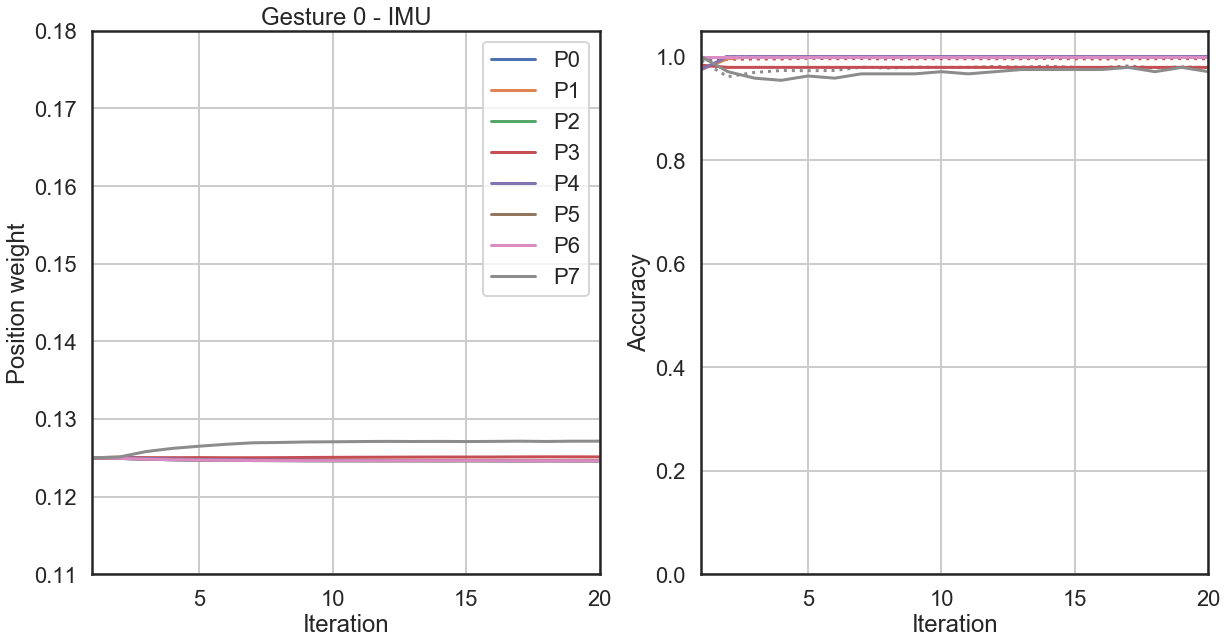

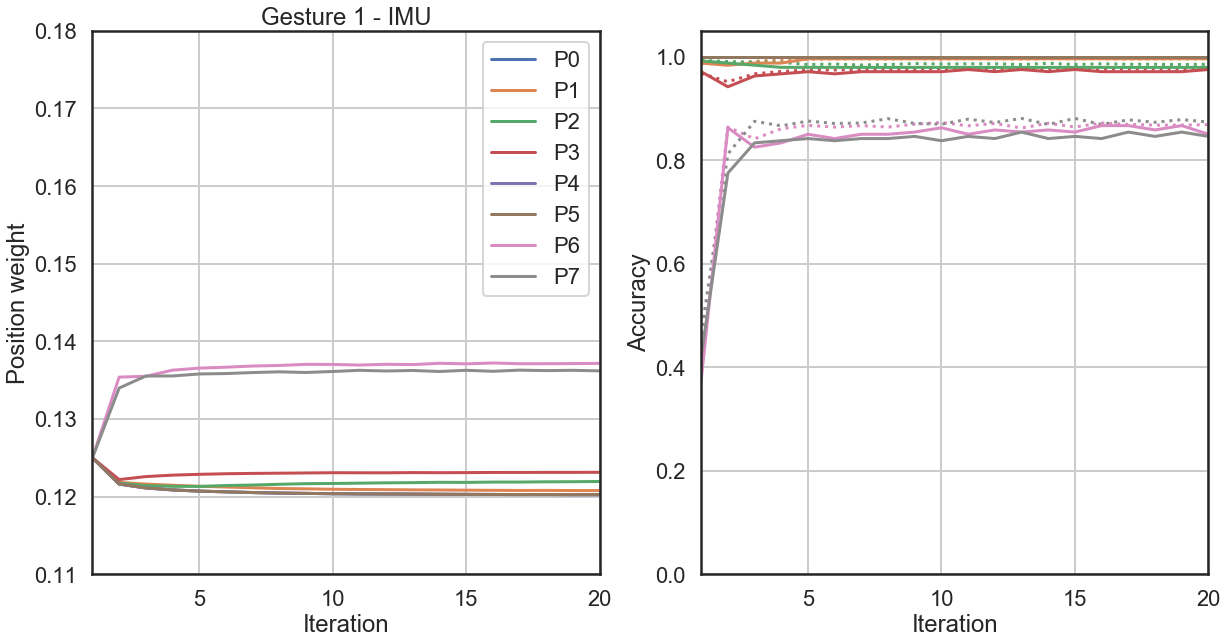

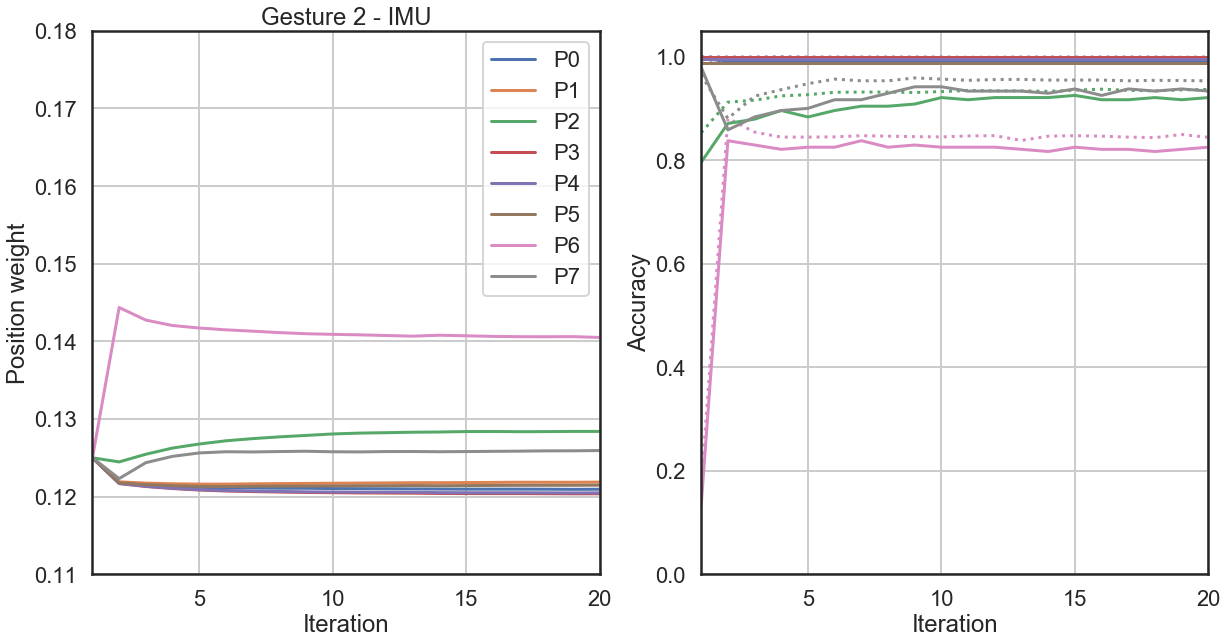

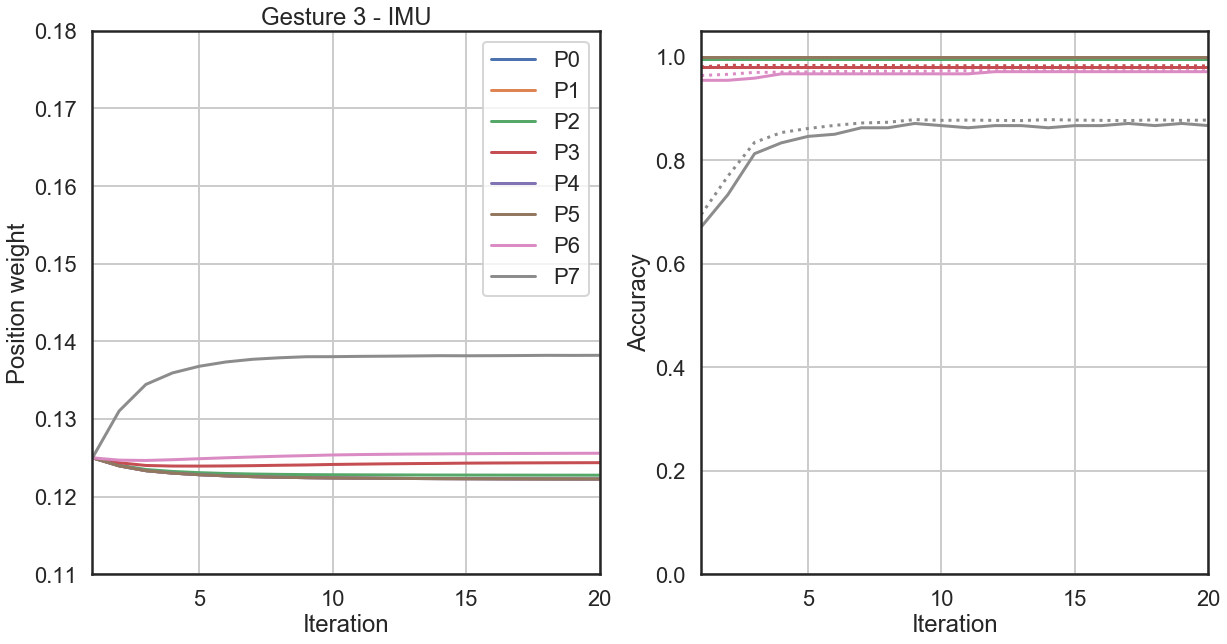

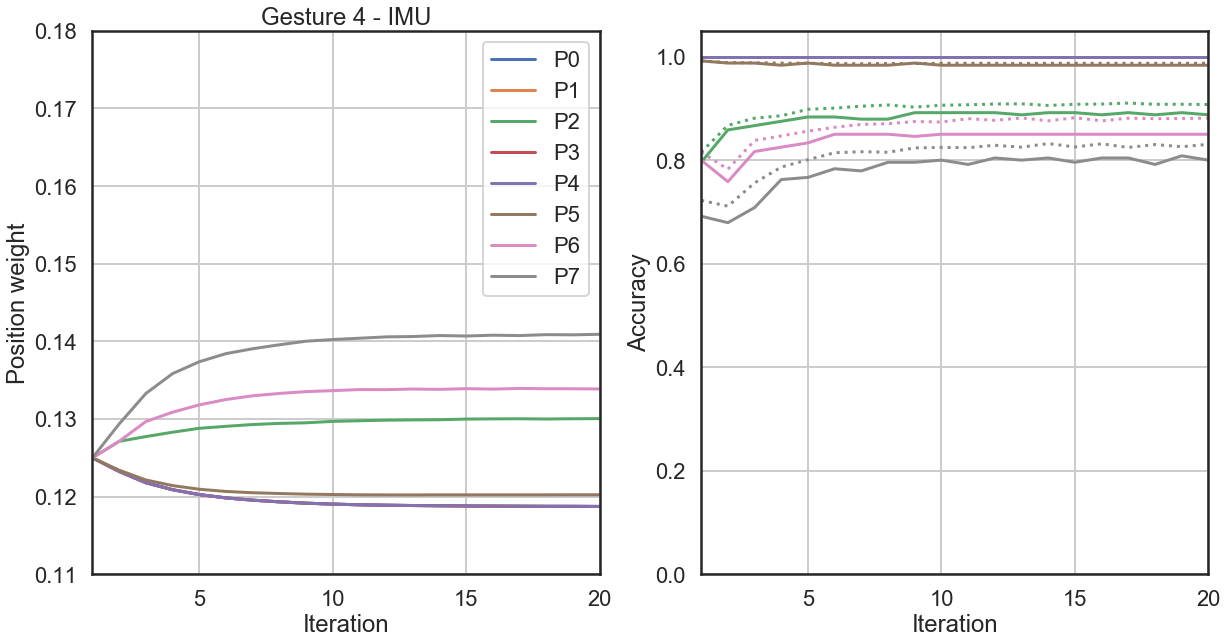

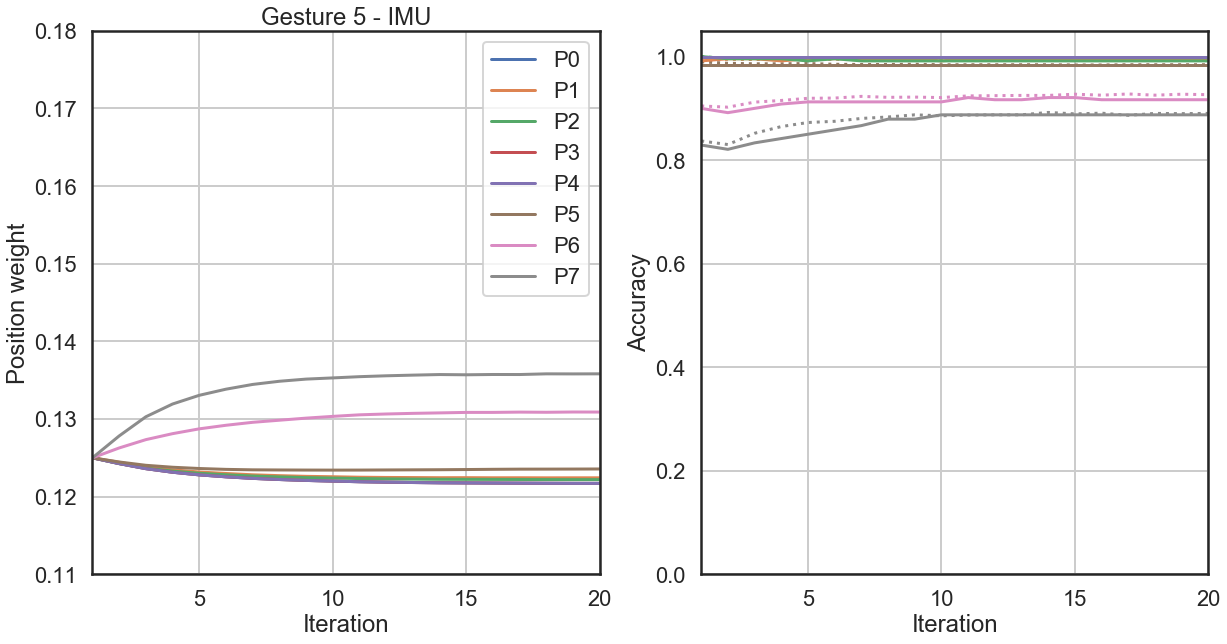

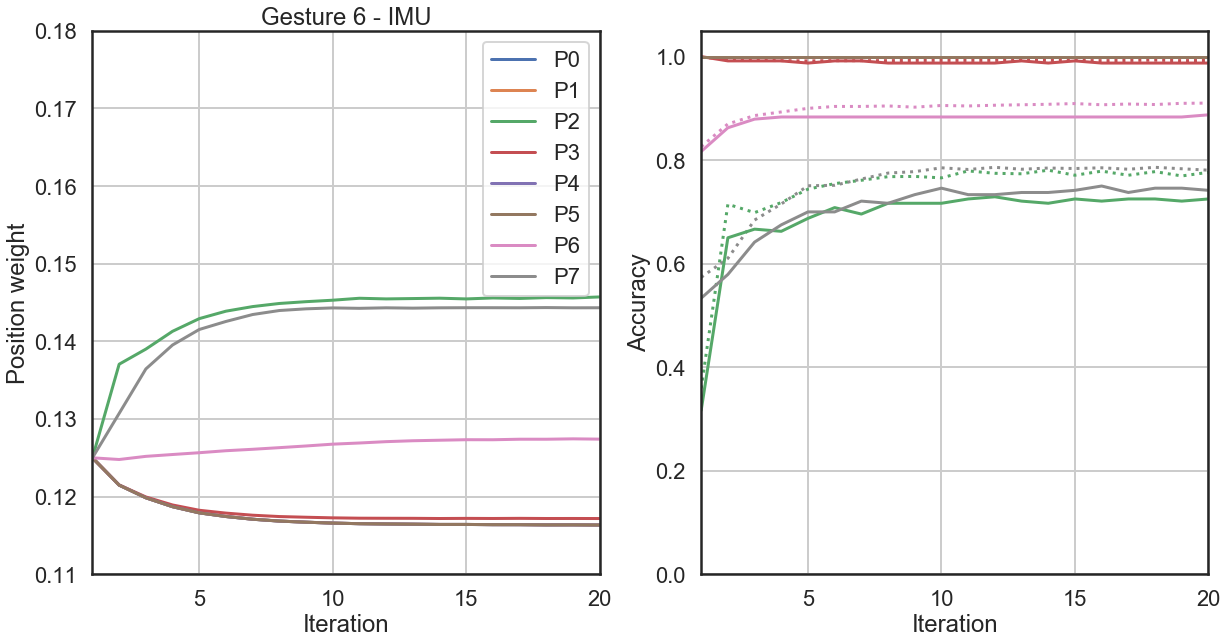

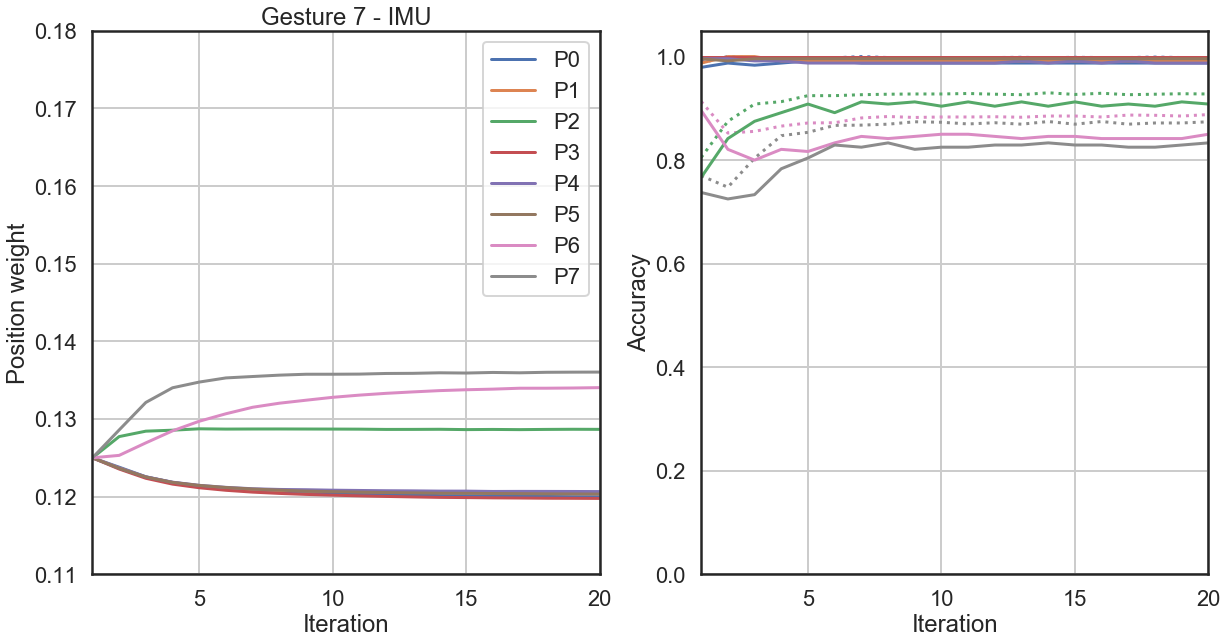

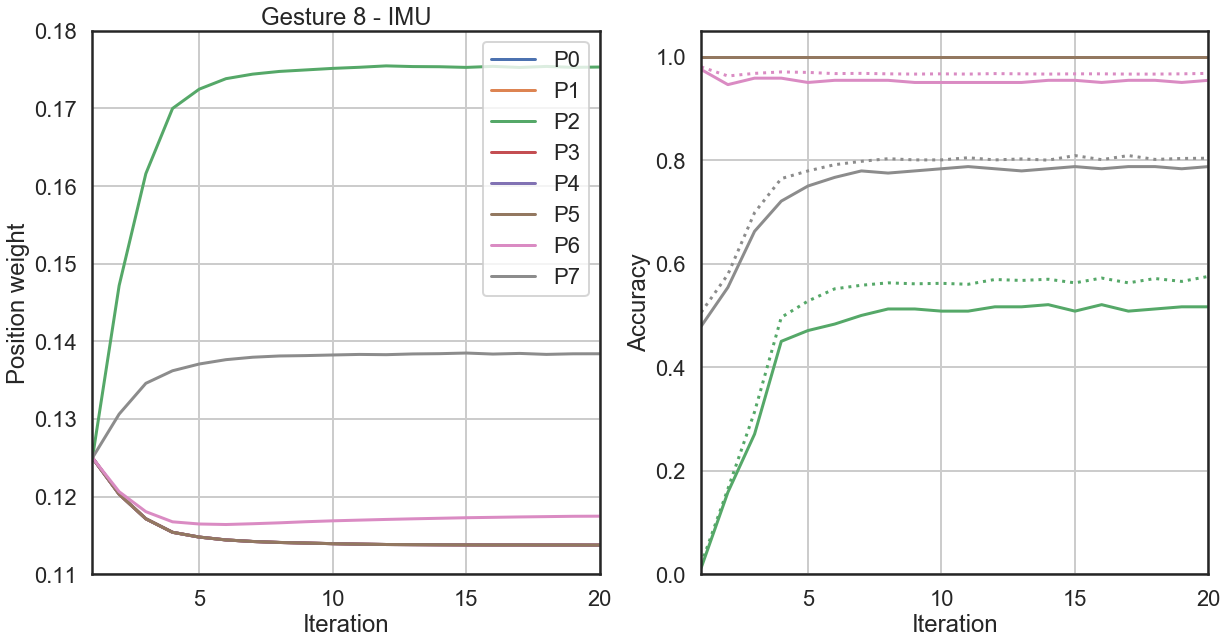

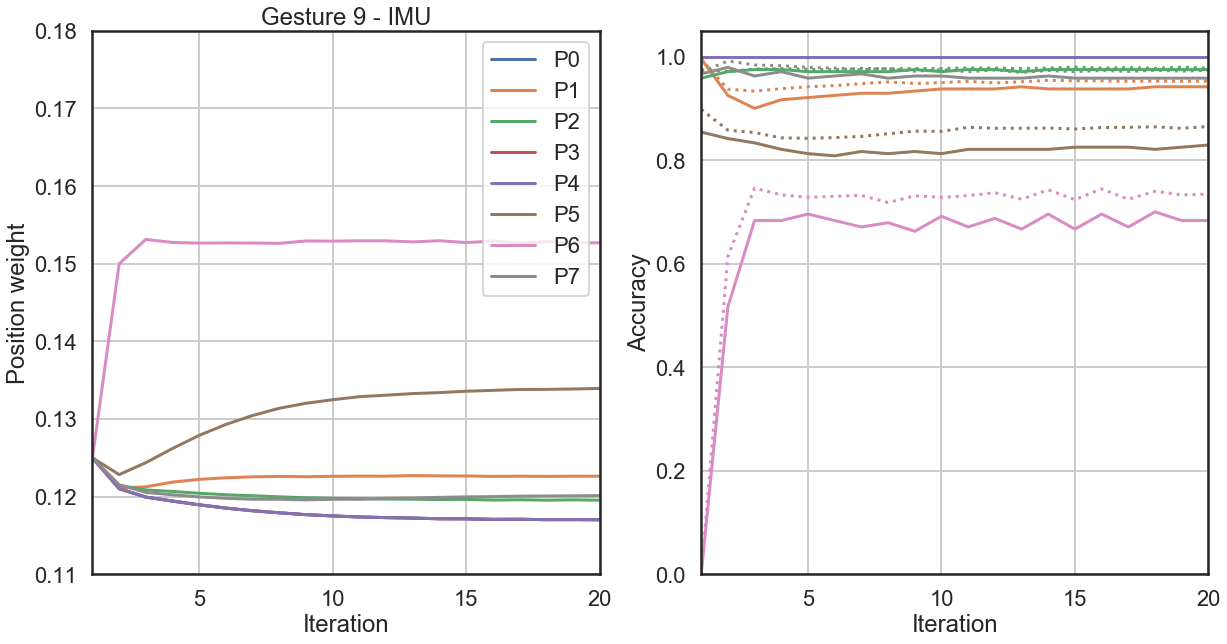

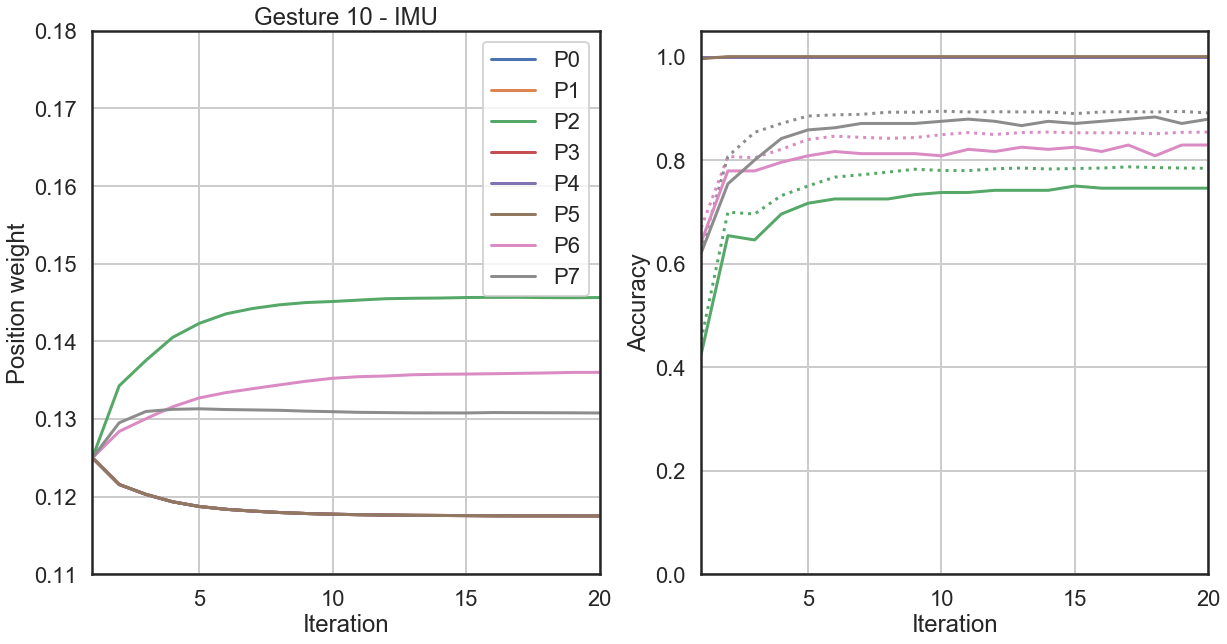

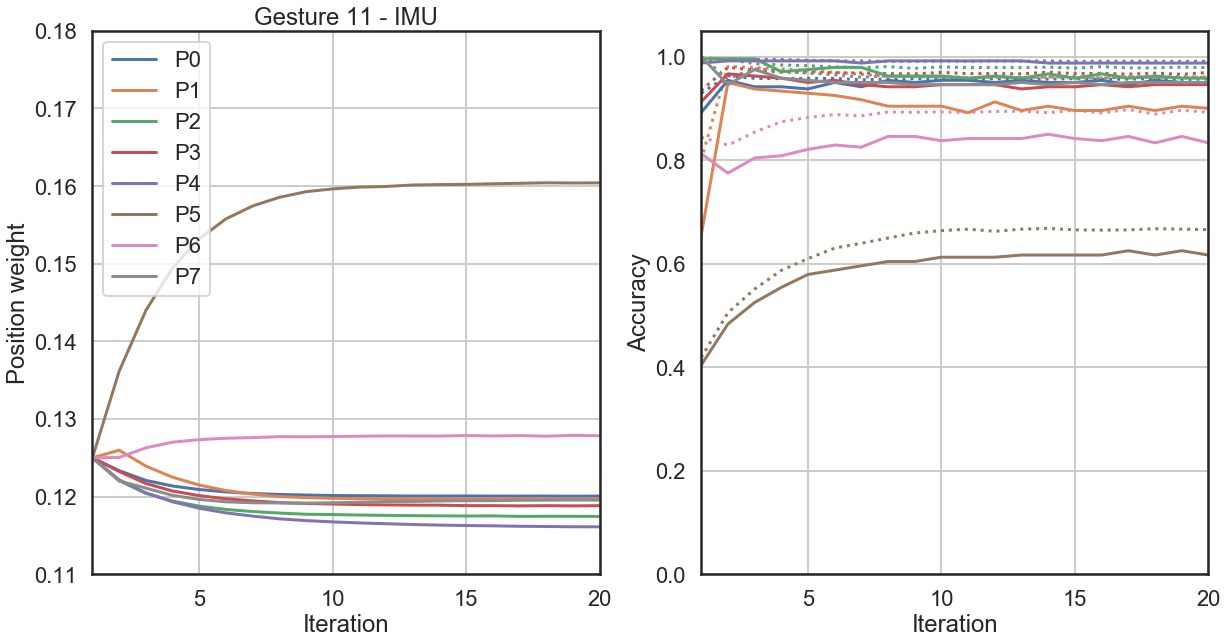

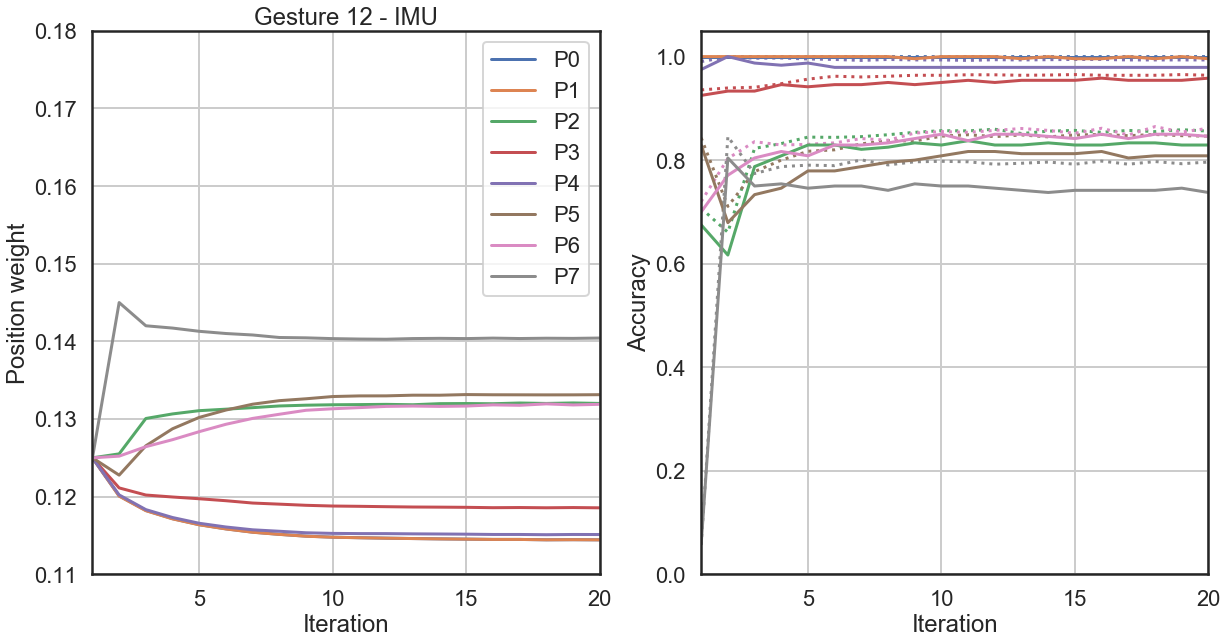

In [21]:
with open('weighted_results.pickle', 'rb') as f:
    res = pickle.load(f)

sns.set_context('poster')
a = np.mean(res['acc'],axis=(0))
pw = np.mean(res['posWeights'],axis=(0))
for g in range(13):
    gTrain = a[:,g,:,0]
    gTest = a[:,g,:,1]
    gPos = pw[:,g,:]
    f,ax = plt.subplots(1,2,figsize=(20,10))

    ax[0].plot(np.arange(1,21),gPos)
    ax[0].set_ylabel('Position weight')
    ax[0].set_ylim((0.11,0.18))
    ax[0].set_xlabel('Iteration')
    ax[0].set_xlim((1,20))
    ax[0].grid(True)
    ax[0].legend(['P%d' % p for p in range(8)])
    ax[0].set_title('Gesture %d - IMU' % g)
    
    ax[1].plot(np.arange(1,21),gTrain,':')
    ax[1].set_prop_cycle(None)
    ax[1].plot(np.arange(1,21),gTest)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim((0,1.05))
    ax[1].set_xlabel('Iteration')
    ax[1].set_xlim((1,20))
    ax[1].grid(True)

    plt.show()

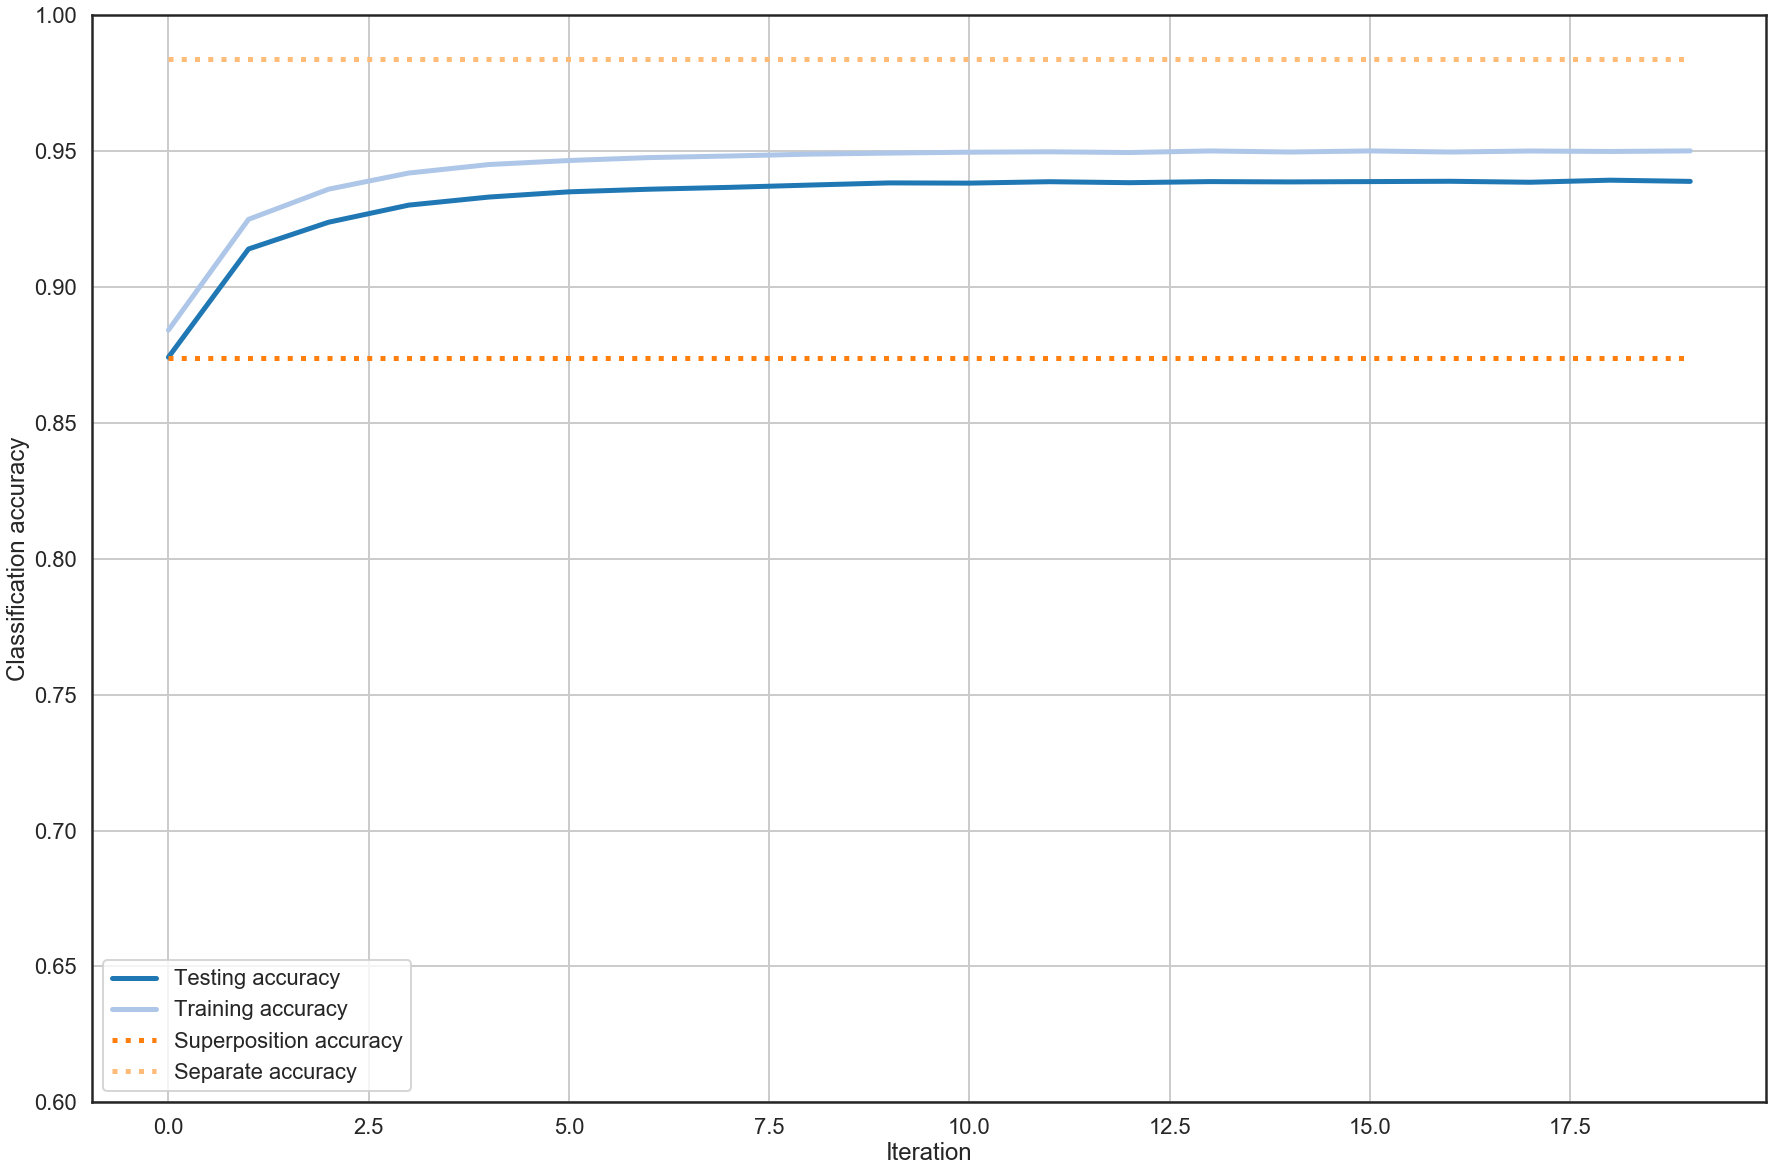

In [26]:
sns.set_context('poster')
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 5

f,ax = plt.subplots(figsize=(30,20))
plt.plot(range(numIter),np.mean(acc[:,:,:,:,1],axis=(0,2,3)))
plt.plot(range(numIter),np.mean(acc[:,:,:,:,0],axis=(0,2,3)))
ax.plot(range(numIter),0.874*np.ones(numIter),':')
ax.plot(range(numIter),0.9838*np.ones(numIter),':')
ax.set_ylim((0.6, 1))
ax.grid(True)
ax.set_xlabel('Iteration')
ax.set_ylabel('Classification accuracy')
ax.legend(['Testing accuracy','Training accuracy','Superposition accuracy','Separate accuracy'])


plt.show()


plt.show()

In [25]:
np.mean(acc[:,:,:,:,1],axis=(0,2,3))

array([0.87411859, 0.91394231, 0.92379808, 0.93008814, 0.93305288,
       0.93497596, 0.9359375 , 0.93661859, 0.93745994, 0.93826122,
       0.93818109, 0.93870192, 0.93834135, 0.93874199, 0.93862179,
       0.93874199, 0.93886218, 0.9385016 , 0.93926282, 0.93882212])

In [10]:
# weights = np.mean(posWeights,axis=0)
# f,ax = plt.subplots(numGestures,numIter,figsize=(30,20))
# for g in range(numGestures):
#     for n in range(numIter):
#         posSplit = weights[n,g,:]
#         ax[g,n].pie(posSplit,colors=pPalette)

In [11]:
# nuXTrain = 20
# skf = StratifiedKFold(n_splits=numSplit)

# X = hv
# y = gestLabel
# c = posLabel
# g = groupGP

# splitIdx = 0
# numIter = 50

# acc = np.zeros((numSplit,numIter,numGestures,numPositions,2))
# posPrototypes = np.zeros((numSplit,numGestures,numPositions,D))
# posWeights = np.ones((numSplit,numIter,numGestures,numPositions,D))


# for trainIdx, testIdx in skf.split(X,g):
#     print('Running cross validation split %d of %d...' % (splitIdx+1, numSplit))
#     XTrain, XTest = X[trainIdx], X[testIdx]
#     yTrain, yTest = y[trainIdx], y[testIdx]
#     cTrain, cTest = c[trainIdx], c[testIdx]
#     gTrain, gTest = g[trainIdx], g[testIdx]
    
#     # gather separate prototype for each gesture performed in each arm position
    
#     for gest in gestures:
#         posPrototypes[splitIdx,gest,:,:] = centroids(XTrain[yTrain==gest],label=cTrain[yTrain==gest])[1]
    
#     # get accuracy from equally weighting each arm position
#     alpha = 0.1
#     for n in range(numIter):
#         AM = np.vstack([centroids(posPrototypes[splitIdx,g,:,:]*posWeights[splitIdx,n,g,:,:])[1][0] for g in gestures])
#         for gest in gestures:
#             for pos in positions:
#                 acc[splitIdx,n,gest,pos,0] = accuracy_score(classify(XTrain[(yTrain==gest) & (cTrain==pos)],AM,'hamming'),yTrain[(yTrain==gest) & (cTrain==pos)])
#                 acc[splitIdx,n,gest,pos,1] = accuracy_score(classify(XTest[(yTest==gest) & (cTest==pos)],AM,'hamming'),yTest[(yTest==gest) & (cTest==pos)])
#         for gest in gestures:
#             if n < numIter - 1:
#                 deltaWeights = softmax(1 - acc[splitIdx,n,gest,:,0]).reshape(-1,1)
#                 posWeights[splitIdx,n+1,gest,:,:] = posWeights[splitIdx,n,gest,:,:] + deltaWeights*alpha
#         alpha *= 0.99
#         print(np.mean(acc[0,n,:,:,0]))
    
#     splitIdx += 1